In [1]:
from models.vit_lit import VitModel
from models.modeling import CONFIGS
from utils.data_utils import get_loader
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
plt.rcParams['figure.dpi'] = 600

In [4]:
model = VitModel.load_from_checkpoint('/home/haotian/Workspace/Transformer/Vit-Pytorch/ViT-pytorch/runs/cifar10-100_500_8/version_0/checkpoints/cifar10-100_500_8-epoch=16-train_loss=1.48e+00.ckpt', strict=False)

In [5]:
import argparse
import shlex
def main(cmd=''):
    parser = argparse.ArgumentParser()
    # Required parameters
    parser.add_argument("--name", required=True,
                        help="Name of this run. Used for monitoring.")
    parser.add_argument("--dataset", choices=["cifar10", "cifar100"], default="cifar10",
                        help="Which downstream task.")
    parser.add_argument("--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16",
                                                 "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"],
                        default="ViT-B_16",
                        help="Which variant to use.")
    parser.add_argument("--pretrained_dir", type=str, default="checkpoint/ViT-B_16.npz",
                        help="Where to search for pretrained ViT models.")
    parser.add_argument("--output_dir", default="output", type=str,
                        help="The output directory where checkpoints will be written.")

    parser.add_argument("--img_size", default=224, type=int,
                        help="Resolution size")
    parser.add_argument("--train_batch_size", default=512, type=int,
                        help="Total batch size for training.")
    parser.add_argument("--eval_batch_size", default=64, type=int,
                        help="Total batch size for eval.")
    parser.add_argument("--eval_every", default=100, type=int,
                        help="Run prediction on validation set every so many steps."
                             "Will always run one evaluation at the end of training.")

    parser.add_argument("--learning_rate", default=3e-2, type=float,
                        help="The initial learning rate for SGD.")
    parser.add_argument("--weight_decay", default=0, type=float,
                        help="Weight deay if we apply some.")
    parser.add_argument("--num_steps", default=10000, type=int,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--decay_type", choices=["cosine", "linear"], default="cosine",
                        help="How to decay the learning rate.")
    parser.add_argument("--warmup_epochs", default=2, type=int,
                        help="Epochs of training to perform learning rate warmup for.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float,
                        help="Max gradient norm.")

    parser.add_argument("--local_rank", type=int, default=-1,
                        help="local_rank for distributed training on gpus")
    parser.add_argument('--seed', type=int, default=42,
                        help="random seed for initialization")
    parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                        help="Number of updates steps to accumulate before performing a backward/update pass.")
    parser.add_argument('--fp16', action='store_true',
                        help="Whether to use 16-bit float precision instead of 32-bit")
    parser.add_argument('--fp16_opt_level', type=str, default='O2',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")
    parser.add_argument('--loss_scale', type=float, default=0,
                        help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
                             "0 (default value): dynamic loss scaling.\n"
                             "Positive power of 2: static loss scaling value.\n")
    if cmd != '':
        args = parser.parse_args(cmd)
    else:
        args = parser.parse_args()

    return args 

args = main(shlex.split('--name cifar10-100_500_rank64  --dataset cifar10 --model_type ViT-B_16 --pretrained_dir checkpoint/ViT-B_16.npz --fp16 --fp16_opt_level O2 --gradient_accumulation_steps 15 --train_batch_size 64  --num_steps 2000'))

In [6]:
from utils.data_utils import get_loader
train_loader, test_loader = get_loader(args)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
layer = 5
head = 0
res = []
for x in train_loader:
    input = x[0]
    _, A = model.model.transformer(input)
    attention = A[layer].detach().numpy()
    s = np.linalg.svd(attention[:,head], compute_uv=False)
    res.append(s)
    if len(res)>20:
        break
    

In [14]:
import pickle
# with open('sigma5.pkl', 'wb') as f:
#     pickle.dump(res, f)

with open('sigma5.pkl', 'rb') as f:
    res = pickle.load(f)

In [15]:
res = np.array(res)
res = res.reshape(-1,197)
res = res[:,:15]/197

In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame(res)
df = pd.melt(df)

In [18]:
average = np.mean(res, axis=0)

[]

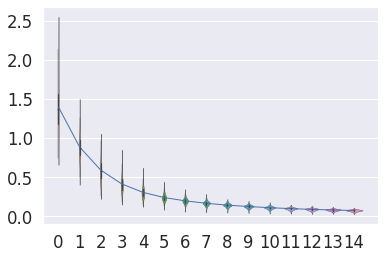

In [19]:
import seaborn as sns

sns.set(font_scale=1.5)
ax = sns.violinplot(data = df, x='variable', y='value', linewidth=0.4, bw = 0.3,  cut=1)
ax.plot(average, linewidth=1)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('layer5.png', dpi=800)
plt.plot()

In [9]:
average

array([1.6087421 , 0.7299827 , 0.54274666, 0.44772035, 0.3832338 ,
       0.32956824, 0.29879928, 0.2638418 , 0.23219989, 0.20169531,
       0.16858909, 0.13439971, 0.1099793 , 0.09101814, 0.07538339],
      dtype=float32)

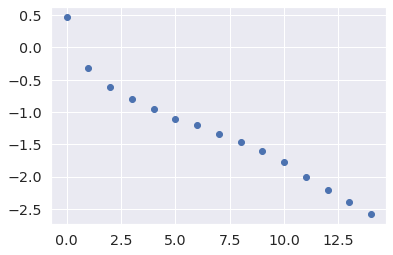

In [13]:
plt.scatter(range(15), np.log(average))

In [20]:
a = np.hstack((np.log(average).reshape(15,1), np.ones((15,1))))
b = 